<a href="https://colab.research.google.com/github/atbolsh/BNN_order_statistics/blob/master/FormulasForRenorm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Renormalizing BNNs using Gaussian Order Statistics.

Binary layers have weights that are either $+1$ or $-1$. If the input activations are similarly quantized (as they often are), that means that the output can be a large integer. Putting several such layers together has the potential of making very large gradients that make training difficult.

In addition, many convolutional neural networks use MaxPooling layers, which take the maximum activation out of $M$ to pass into the next layer. This has the potential to saturate the downstream activations with positive numbers, which, after quantization, might turn into a layer consisting only of $+1$s and carrying no information.

Traditionally, these effects can be corrected with Batch Normalization. In fact, the larq.dev website explicitly recommends putting BatchNorm layers after every MaxPool: https://docs.larq.dev/larq/guides/bnn-architecture/

This does help combat both of these issues, but suffers from several negative effects. First of all, it makes it very difficult for the downstream layer to be very far from $0$. And secondly, it introduces unncessary randomness into the data.

Both of these problems can be seen in the autoencoder images below (all the autoencoder code is in the other python notebook in this repo).

I recommend addressing these issues by training with a fixed normalization, where the exepcted average (based on the assumption of random weights and inputs) is subtracted away, before the expected standard deviation is used to rescale the value (that is, the output is computed using $(x - \mu) / \sigma $ for precomputed $\mu$ and $\sigma$.

These values are easy to compute without MaxPool layers: $\mu = 0$ and $\sigma = \sqrt{N}$, where $N$ is the number of input values.

We can see these positive effects in the second autoencoder outputs below (the two autoencoders are otherwise identical; see the "NewQuantizedAutoencoder" and the "TrueQuantizedAutoencoder" in the other notebook).

However, $\mu$ and $\sigma$ are a little harder to compute for MaxPool layers. Nevertheless, we can use the well-established field of Gaussian Order Statistics to compute these fixed regularizations.

Basically, we will simply use the expected values and expected $\sigma$s of the maximum out of a sample of $M$ iid values from the normal distribution. The next section will build up to code that computes these values; then we will test this by drawing real samples; and finally, we will use this code to slighly improve the accuracy from this BNN tutorial classifier on the larq.dev website: https://docs.larq.dev/larq/tutorials/mnist/

More information on the statistics can be found here (also used as a reference for its table of order statistics): https://projecteuclid.org/euclid.aoms/1177728266

In [1]:
from google.colab import drive
drive.mount('/GDrive')

Mounted at /GDrive


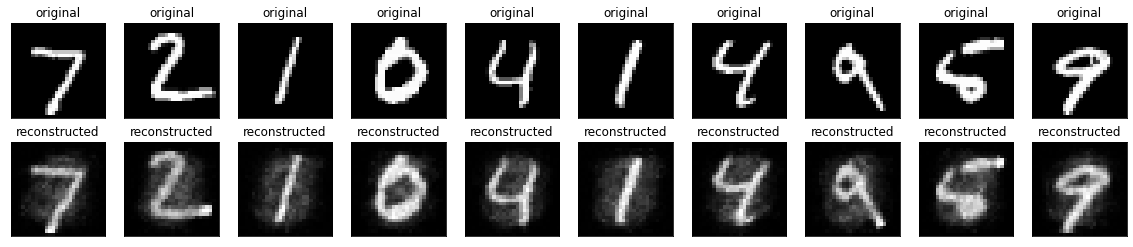

In [3]:
from IPython.display import Image

# Reconstructions from a batchnorm BNN autoencoder. Notice the 'fuzz' from other images, and how far from white the white lines are.
Image("/GDrive/MyDrive/Colab Notebooks/img/MNIST_batchnorm_BNN_autoencoder.png")

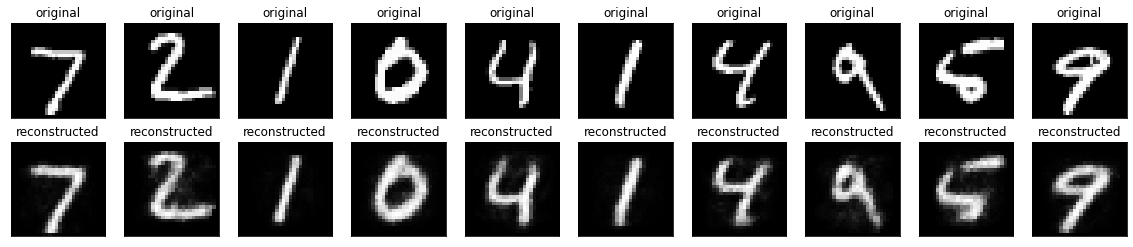

In [4]:
# Same design, hyperparameters, and training epochs; notice how much better a fixed rescaling is! This allows the network to learn strong signals (far from 0, or close to 1 after a sigmoid) where needed, and avoid some of the 'fuzz'
Image("/GDrive/MyDrive/Colab Notebooks/img/MNIST_rescaling_BNN_autoencoder.png")

### NB: Why the mean? Why not the median?

Below, I compute the expected value of the mean of the order distribution, as well as it's standard deviation. At the time, this seemed like the simplest replacement for the BatchNorm layers.

However, it's possible that the median would be better. After all, subtracting the median should provide the best balance between positive and negative numbers (before training), and therefore, the most even mix of $+1$ and $-1$ activations after quantization.

Comparing the two rigorously can be left for another time. However, it's good to know that the median is even easier to compute than the mean, and requires no approximations or table references. Finding the corresponding rescaling factor (to replace $\sigma$) is left as an exercise for the reader.

In [5]:
import math
from scipy.stats import norm

# Unlike the f
def maximalMedian(M, N):
  return math.sqrt(N)*norm.ppf(0.5**(1 / M))


### NB 2: Isn't BatchNorm a regularizer? Won't test accuracy sometimes suffer?

Short answer: yes, but it can be replaced.

It's true that much like Dropout, BatchNorm can introduce randomness that makes the network less prone to overfit, and help improve test set accuracy (usually at the cost of training time).

However, such a regularization should be explicitly chosen, not a necessary feature for basic functionality. I personally would recommend fixed normalizations, as above, with additional regularizers whose parameters can actually be chosen (and finely tuned), such as dropout, block dropout, or some BNN-specific technique that randomly flips bits with some probability.

# Mathematical Introduction and Basic Code

So, the original distribution is $0.5$ chance of a $1$ and a $0.5$ chance of a $-1$. That's a $\mu = 0$ and $\sigma = 1$.

Now, the sample is really $N$ of these summed together. That means $\mu$ is still $0$, but $\sigma = \sqrt{N}$. This will act like a normal, with those parameters, as long as $N$ is respectable ($N > 6$).

Now, let's say we want the maximal distribution of a sample of $M$ of these; that is, we take $M$ from above, then find the maximum.

Well, unfortunately this becomes more challenging, but it's well described here: https://math.stackexchange.com/questions/89030/expectation-of-the-maximum-of-gaussian-random-variables/89037#89037

The function $\Phi$ from above is easily given in python like so:

In [ ]:
import math
from scipy.stats import norm

norm.ppf(0.95)

1.6448536269514722

This means that the (large-$M$) behavior of the above function is best described in the following two functions:

In [ ]:
def maximalMu(M, N):
  return norm.ppf(1 - (1 / M))*math.sqrt(N)

def maximalSig(M, N):
  return (norm.ppf(1 - (1 / (M*math.e))) - norm.ppf(1 - (1 / M)))*math.sqrt(N)

print(maximalMu(10, 100))
print(maximalSig(10, 100))

12.815515655446003
5.0769019903702794


Of course, the real question is whether or not this is a good approximation for low $M$, since a lot of max-pools happen over $4$ numbers, or maximally, $9$ numbers. For that, we can get our answers from mathematica. We use $N = 1$ as an unrealistic, but simplifying condition just to compare cases between each other.

Here is a table of normal order statistics:

http://faculty.washington.edu/heagerty/Books/Biostatistics/TABLES/NormalOrder.pdf

In [ ]:
maximalMu(4, 1)

0.6744897501960817

In [ ]:
#True Value: 1.029

In [ ]:
maximalMu(9, 1)

1.2206403488473496

In [ ]:
# True value: 1.485

In [ ]:
maximalMu(16, 1)

1.5341205443525463

In [ ]:
# Real value: 1.766

In [ ]:
maximalMu(25, 1)

1.7506860712521692

In [ ]:
# Real value: Close to 2

In [ ]:
maximalMu(36, 1)

1.9145058250555569

In [ ]:
# Real value: 2.12

So, not very good! Fortunately, we have this handy table: https://projecteuclid.org/download/pdf_1/euclid.aoms/1177728266

We shall use it to get the $\mu$ and $\sigma$ for all values below $20$.

In [ ]:
# WARNING: table incomplete at http://faculty.washington.edu/heagerty/Books/Biostatistics/TABLES/NormalOrder.pdf and https://projecteuclid.org/download/pdf_1/euclid.aoms/1177728266
# Using childish approximation for 25, 26, and 27
Mmus = [0, 0.56419, 0.84628, 1.02938, 1.16296,\
        1.26721, 1.35218, 1.42360, 1.48501, 1.53875,\
        1.58644, 1.62923, 1.66799, 1.70338, 1.73591,\
        1.76599, 1.79394, 1.82003, 1.84448, 1.86748,\
        1.88917, 1.90969, 1.92916, 1.94767, 1.94767 + 0.0177,
        1.94767 + 0.0177 + 0.0169,\
        1.94767 + 0.0177 + 0.0169 + 0.0161,\
                           2.01371, 2.02852, 2.04276,\
        2.05646, 2.06967, 2.08241, 2.09471, 2.10661,\
        2.11812, 2.12928]

In [ ]:
# Leaving for historical record of where I got difference estimates above.
for i in range(len(Mmus) - 1):
  print(Mmus[i])
  print(Mmus[i + 1] - Mmus[i])

0
0.56419
0.56419
0.28209000000000006
0.84628
0.18309999999999993
1.02938
0.13358000000000003
1.16296
0.10424999999999995
1.26721
0.08496999999999999
1.35218
0.07142000000000004
1.4236
0.061409999999999965
1.48501
0.05374000000000012
1.53875
0.04769000000000001
1.58644
0.042789999999999884
1.62923
0.03876000000000013
1.66799
0.03538999999999981
1.70338
0.03253000000000017
1.73591
0.030079999999999885
1.76599
0.02795000000000014
1.79394
0.026089999999999947
1.82003
0.02444999999999986
1.84448
0.02300000000000013
1.86748
0.021689999999999987
1.88917
0.020520000000000094
1.90969
0.019469999999999876
1.92916
0.018510000000000026
1.94767
0.01770000000000005
1.96537
0.016899999999999915
1.98227
0.016100000000000003
1.99837
0.015340000000000131
2.01371
0.014809999999999768
2.02852
0.01424000000000003
2.04276
0.013700000000000045
2.05646
0.013209999999999944
2.06967
0.012739999999999974
2.08241
0.0123000000000002
2.09471
0.0118999999999998
2.10661
0.01150999999999991
2.11812
0.0111600000000002

In [ ]:
# And the Msig, coming from this table: https://projecteuclid.org/download/pdf_1/euclid.aoms/1177728266 (Table II)
# TableII is the expectation of x^2; as usuall, the squared mean can be subtraced for the variance.
TableII = [1.0, 1.0, 1.27566, 1.55132, 1.80002,\
           2.02174, 2.22030, 2.39953, 2.56262, 2.71210,\
           2.85003, 2.97802, 3.09740, 3.20924, 3.31444,\
           3.41374, 3.50766, 3.59705, 3.68205, 3.76316]

Mvar = [TableII[i] - (Mmus[i]**2) for i in range(min(len(TableII), len(Mmus)))]

Msig = [math.sqrt(x) for x in Mvar]

In [ ]:
Msig

[1.0,
 0.8256449866013843,
 0.7479773804066537,
 0.7012109636906714,
 0.6689873230488004,
 0.6449176814912118,
 0.62602655502782,
 0.6106496868090576,
 0.5978003846602978,
 0.5868120972679414,
 0.5772678116784267,
 0.5688845287929705,
 0.5614350896586349,
 0.5547400973428911,
 0.5486861324108707,
 0.543156809678384,
 0.5379956100192635,
 0.5334236581742506,
 0.5290969000098188,
 0.5250509019133288]

In [ ]:
for i in range(20):
  print(maximalSig(i + 1, 1))

inf
0.9004525966377902
0.7312296296172752
0.6542321994286818
0.608044425651108
0.5764209843484435
0.5530063663994136
0.5347476096624248
0.5199752191525362
0.507690199037028
0.49725367965384404
0.4882356422575147
0.4803346335448706
0.4733322161869702
0.467065698220106
0.4614110654864225
0.4562718945028028
0.4515719181236393
0.44724990229298367
0.44325603026274885


In [ ]:
# We need 1st order corrections to make it work; probably won't decrease substantially within the domain we actually care about, M > 100
trueMuDif = Mmus[-1] - maximalMu(len(Mmus), 1)
trueSigDif = Msig[-1] - maximalSig(len(Msig), 1)
print(trueMuDif)
print(trueSigDif)

0.20287684703601716
0.08179487165057997


In [ ]:
#Which Leads to this hacky 'true' func:
def trueMaximalStats(M, N):
  scale = math.sqrt(N)

  if M <= len(Mmus):
    mu = Mmus[M - 1]
  else:
    mu = maximalMu(M, 1) + trueMuDif
  if M <= len(Msig):
    sig = Msig[M - 1]
  else:
    sig = maximalSig(M, 1) + trueSigDif

  return scale*mu, scale*sig

In [ ]:
inds = [i + 1 for i in range(50)]
m = []
s = []
for i in inds:
  a, b = trueMaximalStats(i, 1)
  m.append(a)
  s.append(b)

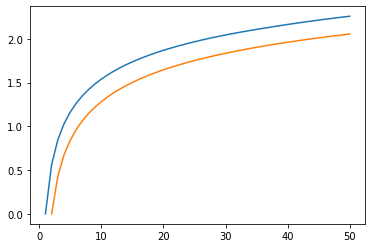

In [ ]:
import matplotlib.pyplot as plt

plt.plot(inds, m)
plt.plot(inds, [maximalMu(i, 1) for i in inds])

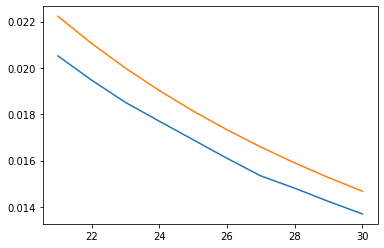

In [ ]:
plt.plot(inds[20:30], [m[i] - m[i - 1] for i in inds[20:30]])
plt.plot(inds[20:30], [maximalMu(i+1, 1) - maximalMu(i, 1) for i in inds[20:30]])

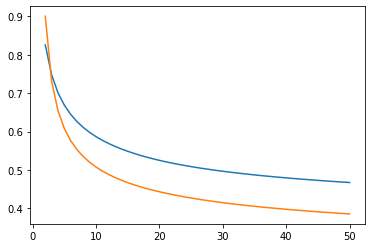

In [ ]:
plt.plot(inds[1:], s[1:])
plt.plot(inds[1:], [maximalSig(i, 1) for i in inds[1:]])

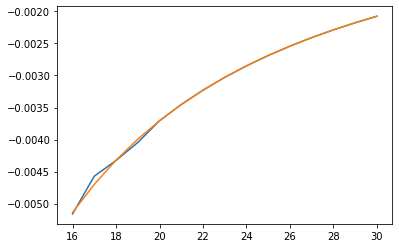

In [ ]:
plt.plot(inds[15:30], [s[i] - s[i - 1] for i in inds[15:30]])
plt.plot(inds[15:30], [maximalSig(i+1, 1) - maximalSig(i, 1) for i in inds[15:30]])

In [ ]:
# The sigs especially seem farish off, but that's something the statistic should be able to handle.
# I really like how smooth the lin is; that is really encouraging. I don't think we'd see assymptotic behavior any faster than this.
# All that's left is statistically testing these results at 4, 9, 16, 25, 36, 49, and 64. Keep N much larger.
# If it holds out, then these stats can be used for proper normalization.

# Testing the code

In [ ]:
import numpy as np

N = 1000
Ms = [4, 9, 16, 25, 36, 49, 64, 81]
samples = 1000

def sample(M, N):
  res = []
  for i in range(M):
    arr = np.random.randint(-1, 1, N)*2 + 1
    res.append(sum(arr))
  return max(res)

sample(4, 1000)

110

In [ ]:
def get_stats(M, N, samples):
  s = []
  for i in range(samples):
    s.append(sample(M, N))
  mu = np.mean(s)
  sig = np.std(s)
  return mu, sig

get_stats(4, 1000, 1000)

(31.142, 22.141992593260436)

In [ ]:
trueMaximalStats(4, 1000)

(32.55185377824126, 22.174237655441505)

In [ ]:
get_stats(9, 1000, 1000)

(46.568, 18.262239074111367)

In [ ]:
trueMaximalStats(9, 1000)

(46.960139481266445, 18.904108016513238)

In [ ]:
get_stats(16, 1000, 1000)

(56.028, 17.536453917482863)

In [ ]:
trueMaximalStats(16, 1000)

(55.84550725080756, 17.176126452142817)

In [ ]:
get_stats(25, 1000, 1000)

(62.358, 16.91401300697147)

In [ ]:
trueMaximalStats(25, 1000)

(62.14413189433094, 16.089108127335003)

In [ ]:
get_stats(36, 1000, 1000)

(67.078, 15.696430039980429)

In [ ]:
trueMaximalStats(36, 1000)

(66.98083557555847, 15.35292341583372)

In [ ]:
get_stats(49, 1000, 1000)

(71.11, 15.155853654611473)

In [ ]:
trueMaximalStats(49, 1000)

(71.09647154733379, 14.812399066143952)

In [ ]:
get_stats(64, 1000, 1000)

(74.632, 14.577811083972792)

In [ ]:
trueMaximalStats(64, 1000)

(74.52702748979941, 14.393485197179785)

In [ ]:
get_stats(81, 1000, 1000)

(77.296, 13.962535013384928)

In [ ]:
trueMaximalStats(81, 1000)

(77.44653208429611, 14.056162811290994)

In [ ]:
get_stats(100, 1000, 1000)

(79.594, 13.303802614290397)

In [ ]:
trueMaximalStats(100, 1000)

(79.98110833006947, 13.776697981461552)

In [ ]:
# Beautiful! This all clearly works for large $N$. But what about smaller $N$? such as

In [ ]:
get_stats(4, 32, 1000)

(6.018, 3.9511613482620525)

In [ ]:
trueMaximalStats(4, 32)

(5.8230526273424665, 3.9666482197442217)

In [ ]:
get_stats(9, 32, 1000)

(8.254, 3.261208978277841)

In [ ]:
trueMaximalStats(9, 32)

(8.40048512903868, 3.3816696463137856)

In [ ]:
# VERY good. So, it seems like all the interpolations payed off! I am ready to use the trueMaximalStats function to create and use a keras layer.

# Using the Code to create and use a keras layer.

In [ ]:
import numpy as np

In [ ]:
pip install larq

     |████████████████████████████████| 71kB 5.9MB/s 
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp36-none-any.whl size=15358 sha256=7f8c93667ca2a032a2d2552f58c8cb7ddb7e8cecd12eed9c0f71acecd0fde359
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built terminaltables


In [ ]:
import tensorflow as tf
import larq as lq

In [ ]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

train_images = train_images.reshape((60000, 28, 28, 1))
test_images = test_images.reshape((10000, 28, 28, 1))

# Normalize pixel values to be between -1 and 1
train_images, test_images = train_images / 127.5 - 1, test_images / 127.5 - 1

11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist, mnist
from tensorflow.keras.models import Model

In [ ]:
class CustomRenorm(Model):
  def __init__(self, M, N, origSig=1.0): # origSig is sigma before all the sums. 
    super(CustomRenorm, self).__init__()
    self.mu, self.sig = trueMaximalStats(M, N)
    self.mu *= origSig
    self.sig *= origSig

  def call(self, x):
    return (x - self.mu) / self.sig



In [ ]:
# All quantized layers except the first will use the same options
kwargs = dict(input_quantizer="ste_sign",
              kernel_quantizer="ste_sign",
              kernel_constraint="weight_clip")

model = tf.keras.models.Sequential()

# In the first layer we only quantize the weights and not the input
l1 = lq.layers.QuantConv2D(32, (3, 3),
                                kernel_quantizer="ste_sign",
                                kernel_constraint="weight_clip",
                                use_bias=False,
                                input_shape=(28, 28, 1))
model.add(l1)
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
#model.add(tf.keras.layers.BatchNormalization(scale=False))
model.add(CustomRenorm(4, 9))#, math.sqrt(1 / 6))) # Comes from 9 pixels; uniform distribution between -1 and 1 (after multiplication by weights.)
# Oddly, using the correct value above - math.sqrt(1 / 6) - hurts final accuracy. Fluke?
# SOLVED: Comes from MNIST and it's almost-binary activations. fashion_mnist performs better with correct regularizer.
# I suggest a proper batchNorm insead of this guesswork in ONLY THIS LAYER.

l2 = lq.layers.QuantConv2D(64, (3, 3), use_bias=False, **kwargs)
model.add(l2)
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
#model.add(tf.keras.layers.BatchNormalization(scale=False))
model.add(CustomRenorm(4, 9*32)) # Comes from 9 32-bit pixes

model.add(lq.layers.QuantConv2D(64, (3, 3), use_bias=False, **kwargs))
#model.add(tf.keras.layers.BatchNormalization(scale=False))
model.add(CustomRenorm(1, 64*9)) # No max-pooling, but 9 64-bit pixels.
model.add(tf.keras.layers.Flatten())

model.add(lq.layers.QuantDense(64, use_bias=False, **kwargs))
#model.add(tf.keras.layers.BatchNormalization(scale=False))
model.add(CustomRenorm(1, 64))
model.add(lq.layers.QuantDense(10, use_bias=False, **kwargs))
#model.add(tf.keras.layers.BatchNormalization(scale=False))
model.add(CustomRenorm(1, 64))
model.add(tf.keras.layers.Activation("softmax"))

In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(train_images, train_labels, batch_size=64, epochs=6)

test_loss, test_acc = model.evaluate(test_images, test_labels)

Epoch 1/6
938/938 [==============================] - 11s 4ms/step - loss: 0.7048 - accuracy: 0.7807
Epoch 2/6
938/938 [==============================] - 3s 3ms/step - loss: 0.1364 - accuracy: 0.9643
Epoch 3/6
938/938 [==============================] - 3s 3ms/step - loss: 0.0973 - accuracy: 0.9734
Epoch 4/6
938/938 [==============================] - 3s 3ms/step - loss: 0.0856 - accuracy: 0.9775
Epoch 5/6
938/938 [==============================] - 3s 3ms/step - loss: 0.0752 - accuracy: 0.9813
Epoch 6/6
313/313 [==============================] - 1s 2ms/step - loss: 0.0666 - accuracy: 0.9837


In [ ]:
print(f"Test accuracy {test_acc * 100:.2f} %")

Test accuracy 98.37 %


In [ ]:
# Totoal sucess! 1.16% more accuracy!! Errors down by 40%
# BatchNorms everywhere need to go. And now I have the evidence I need.

Except for after the first layer - where a proper batchnorm may or may not be preferred - the new method seems to be better than the old. It's certainly always competitive.

It needs to be tested rigorously in more settings, with more BNN architectures and with more datasets. I suspect it will often deliver train-side improvements, but it won't act as a regularizer at all.

If we really want to add a regularizer, we should use something better controlled, such as dropout, block dropout, or some version of thermal noise during training.

In [ ]:
# Save in github; ping Roeland. Play with SOTAs tmr, start Pi-ification.